# Создание коэффициентов благополучия стран

In [1]:
import sys
# Добавим папку проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [ ]:
from typing import Tuple
import numpy as np 
from numpy.linalg import norm
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px

from utils.constants import (
    F, 
    TARGET_FEATURE,
)
from utils.graphics import (
    display_corellation_by_target,
)
from utils.display_content import (
    dislay_some_fields_description,
)
from utils.prepare_data import (
    move_column_to_end_table,
    add_child_mortality_data,
    move_column_to_end_table,
)
from utils.helpers import get_cosine

from warnings import simplefilter
simplefilter('ignore')

In [3]:
# Загрузим таблицу
data = pd.read_csv('../data/cumulative_life_expectancy_prepared.csv')

# Для случая, если запускаем файл повторно после добавления коэффициентов, удалим поля с ними
columns = list(data.columns)

if (F.PositiveCoef.value in columns):
    data.drop(columns=[F.PositiveCoef.value], inplace=True)
if (F.NegativeCoef.value in columns):
    data.drop(columns=[F.NegativeCoef.value], inplace=True)

data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,1,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,31.86,44.36,4.26,1.47,14.55,992.698979,17943712.0,5.222375,1,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,33.29,45.35,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,1,52.36


Добавим в таблицу данные о детской смертности.\
Поскольку данные эти есть только до 2017 года, после добавления в таблице остануться данные за 2000-2017 гг.

In [4]:
cumulative_data = add_child_mortality_data(data)

# Переставим столбец с таргетом в конец таблицы
cumulative_data = move_column_to_end_table(cumulative_data, F.LifeExpectancy.value)
cumulative_data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,0.029,0.20,0.095,0.091,0.036,0.21,0.027,0.038,0.087,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,0.030,0.19,0.093,0.090,0.035,0.20,0.027,0.037,0.087,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,0.032,0.18,0.093,0.092,0.037,0.21,0.028,0.037,0.087,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,0.034,0.18,0.099,0.097,0.039,0.21,0.029,0.039,0.091,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,0.036,0.18,0.100,0.100,0.041,0.22,0.030,0.040,0.094,52.36


In [5]:
# Выведем описание полей
dislay_some_fields_description(list(cumulative_data.columns))

**Описание полей:**

- `ParentLocationCode` - Код региона

- `ParentLocation` - Название региона

- `SpatialDimValueCode` - Код страны

- `Location` - Название страны

- `Period` - Год

- `AdultMortality` - Смертность среди взрослого населения от 15 до 60 лет (в % от численности населения)

- `Homicides` - Оценка уровня убийств (%)

- `MaternalMortality` - Коэффициент материнской смертности (%)

- `AdultNcdMortality` - Вероятность (в %) смерти в возрасте от 30 до 70 лет от сердечно-сосудистых заболеваний, рака, диабета или хронических респираторных заболеваний

- `AdultNcdMortality117` - Смертность взрослых от неинфекционных заболеваний (%). Респираторные заболевания

- `AdultNcdMortality110` - Смертность взрослых от неинфекционных заболеваний (%). Сердечно-сосудистые заболевания

- `AdultNcdMortality080` - Смертность взрослых от неинфекционных заболеваний (%). Сахарный диабет

- `AdultNcdMortality061` - Смертность взрослых от неинфекционных заболеваний (%). Злокачественные новообразования

- `AdultNcdMortalitySum` - Сумма причин (в %) смертности взрослых от неинфекционных заболеваний.

- `PoisoningMortality` - Уровень смертности от непреднамеренного отравления (%)

- `SuicideMortality` - Стандартизированные по возрасту показатели самоубийств (%)

- `AlcoholСonsumption` - Потребление алкоголя на душу населения (15+) (в литрах чистого алкоголя)

- `HepatitisBImmunization` - Охват иммунизацией детей в возрасте 1 года против гепатита В (ГепВ3) (%)

- `MeaslesImmunization` - Охват первой дозой вакцины, содержащей коревой компонент (MCV1), среди детей в возрасте 1 года (%)

- `PolioImmunization` - Охват иммунизацией от полиомиелита (Pol3) среди детей в возрасте 1 года (%)

- `DiphtheriaImmunization` - Охват иммунизацией детей в возрасте 1 года дифтерийно-столбнячным анатоксином и коклюшем (АКДС3) (%)

- `BmiAdultUnderweight` - Распространенность недостаточного веса среди взрослых, ИМТ < 18,5 (стандартизированная по возрасту оценка) (%)

- `BmiAdultOverweight25` - Распространенность избыточного веса среди взрослых, ИМТ >= 25 (стандартизированная по возрасту оценка) (%)

- `BmiAdultOverweight30` - Распространенность ожирения среди взрослых, ИМТ >= 30 (стандартизированная по возрасту оценка) (%)

- `BmiChildThinness` - Распространенность худобы среди детей 5-9 лет, ИМТ < -2 стандартных отклонений ниже медианы (грубая оценка) (%)

- `BmiTeenagerThinness` - Распространенность худобы среди подростков 10-19 лет, ИМТ < -2 стандартных отклонений ниже медианы (грубая оценка) (%)

- `BmiChildOverweight1` - Распространенность избыточного веса среди детей 5-9 лет, ИМТ > +1 стандартного отклонения выше медианы (грубая оценка) (%)

- `BmiTeenagerOverweight1` - Распространенность избыточного веса среди подростков 10-19 лет, ИМТ > +1 стандартного отклонения выше медианы (грубая оценка) (%)

- `BmiChildOverweight2` - Распространенность ожирения среди детей 5-9 лет, ИМТ > +2 стандартных отклонений выше медианы (грубая оценка) (%)

- `BmiTeenagerOverweight2` - Распространенность ожирения среди подростков 10-19 лет, ИМТ > +2 стандартных отклонений выше медианы (грубая оценка) (%)

- `Sanitation` - Население, пользующееся как минимум базовыми услугами санитарии (%)

- `DrinkingWater` - Население, пользующееся по крайней мере базовыми услугами питьевого водоснабжения (%)

- `HealthCareCosts` - Общие внутренние государственные расходы на здравоохранение в процентах от общих государственных расходов (%)

- `HealthCareCostsGdp` - Общие внутренние государственные расходы на здравоохранение в процентах от валового внутреннего продукта (ВВП) (%)

- `HealthCareCostsPerCapita` - Общие внутренние государственные расходы на здравоохранение на душу населения в долларах США

- `GdpPerCapita` - ВВП на душу населения (в долл. США)

- `Population` - Общая численность населения

- `Schooling` - Средняя продолжительность формального образования для лиц в возрасте 15–64 лет

- `ClusterKMeans` - Кластер страны, определенный с помощью k-means

- `ChildUnder5Mortality2` - Распределение причин смерти среди детей в возрасте до 5 лет (%). ВИЧ/СПИД.

- `ChildUnder5Mortality5` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Столбняк.

- `ChildUnder5Mortality6` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Корь.

- `ChildUnder5Mortality7` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Менингит/энцефалит.

- `ChildUnder5Mortality8` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Малярия.

- `ChildUnder5Mortality12` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Сепсис и другие инфекционные состояния новорожденных.

- `ChildUnder5Mortality3` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Диарейные заболевания.

- `ChildUnder5Mortality11` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Родовая асфиксия и родовая травма.

- `ChildUnder5Mortality13` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие инфекционные, перинатальные и алиментарные состояния.

- `ChildUnder5Mortality17` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Травмы.

- `ChildUnder5Mortality9` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Острые инфекции нижних дыхательных путей.

- `ChildUnder5Mortality16` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие неинфекционные заболевания.

- `ChildUnder5Mortality15` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Врожденные аномалии.

- `ChildUnder5Mortality10` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Недоношенность.

- `LifeExpectancy` - Ожидаемая продоложительность жизни

Посмотрим на корреляцию признаков с целевой переменной.

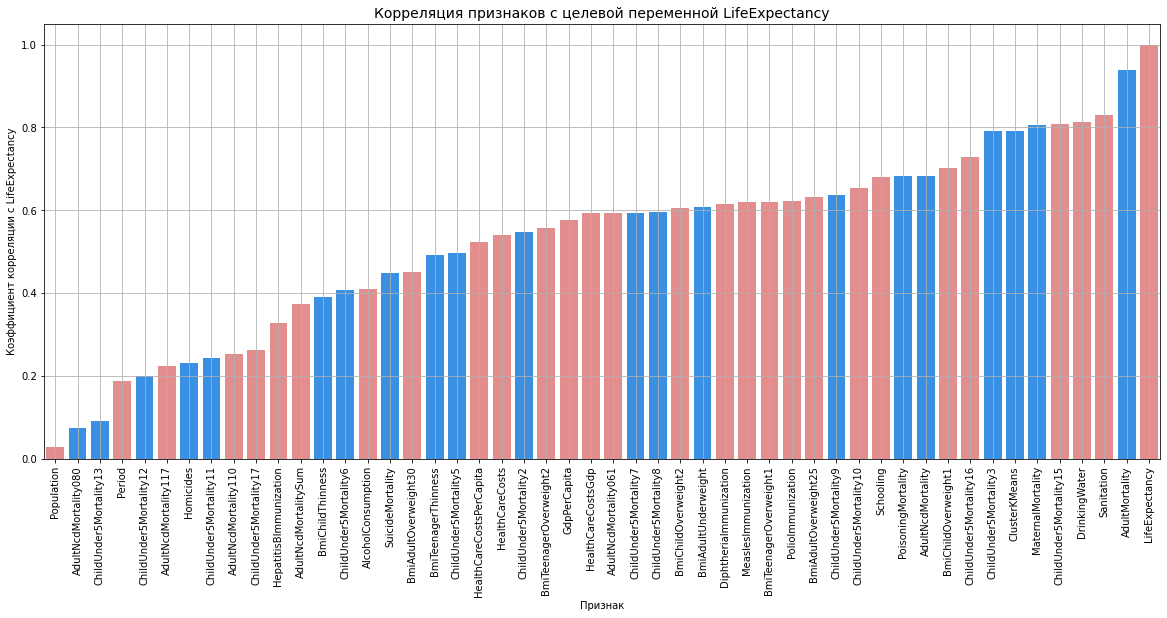

In [6]:
display_corellation_by_target(cumulative_data, figsize=(20, 8))

## Описание алгоритма формирования коэффициентов

Создадим два коэффициента.

- Коэффициент благополучия страны.
- Коэффициент неблагополучия страны.

Идея формирования коэффициентов состоит в следующем.

Часть признаков положительно коррелируют с ожидаемой продолжительностью жизни, часть отрицательно.

То есть, часть факторов способствуют/положительно сочетаются с высокой продолжительностью жизни и являются признаками благополучной страны.\
А часть фаторов отрицательно влияют на продолжительность жизни и являются признаками неблагополучной страны.

**Разделим все признаки на 2 группы.**

- Признаки, положительно коррелирующие с целевой переменной
- Признаки, отрицательно коррелирующие с целевой переменной

Из этих признаков исключим те, которые прямого отношения к благополучию (или не благополучию) не имеют.\
Список их соберем ниже.

**Далее из этих двух групп соберем два вектора.**

Первый вектор будем собирать из данных стран с кластером `ClusterKMeans == 0`, \
в который ранее вошли благополучные страны.\
Второй вектор будем собирать из данных стран с кластером `ClusterKMeans == 1`, \
в который ранее вошли неблагополучные страны.

Условно, составим идеальный вектор благополучной страны.\
По признакам, положительно коррелирующим с целевым, \
возьмем в группе стран с `ClusterKMeans == 0` максимальные средние по годам значения.

И составим вектор максимально неблагополучной страны.\
По признакам, отрицательно коррелирующим с целевым, \
возьмем по группе стран с `ClusterKMeans == 1` максимальные средние по годам значения.

Далее **коэффициент благополучия** посчитаем как косинус угла вектора средних данных по каждой стране с полученным идеальным вектором.\
Косинус угла будет означать степень сонаправленности вектра данной страны с вектором идеальной страны.\
Чем косинус больше, тем угол меньше, соответственно сонаправленность больше.

**Коэффициент неблагополучия** страны посчитаем как косинус угла вектора средних данных по каждой стране с полученным вектором максимально неблагополучной страны.\
Косинус угла будет означать степень сонаправленности вектора данной страны с вектором максимально неблагополучной страны.

## Формирование коэффициентов

Напишем функцию, которая будет делить признаки на две группы.\
С положительной и отрицательной корреляцией с целевой переменной.

In [7]:
def get_split_correlation_fields(
    data: pd.DataFrame, 
    method: str = 'pearson',
    target_feature_name: str = TARGET_FEATURE,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Формирует две таблицы. 
    Одну с признаками, положительно коррелирующими с целевой переменной 
    (в формате: индекс - имя признака, значение - коэффициент корреляции).
    И вторую аналогичную с отрицательно коррелирующими признаками

    Args:
        data (pd.DataFrame): Данные, которые проверяем на корреляцию с целевой переменной
        method (str, optional): Метод, с помощью которого считается коэффициент корреляции. 
            По умолчанию 'pearson'.
        target_feature_name (str, optional): Имя целевой переменной. 
            По умолчанию - константа TARGET_FEATURE.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: таблицы данными признаков корреляции
    """
    # Матрица корреляции
    data_corr = data.select_dtypes(include=np.number).corr(method=method)

    # Оставим в таблице только целевую переменную
    data_corr = data_corr[[target_feature_name]]
    
    # Имя поля для значений коэффициента корреляции
    corr_field_name = 'Correlation'
    # Переименуем
    data_corr.rename(columns={ target_feature_name: corr_field_name }, inplace=True)
    
    # Маски для положительной и отрицательной корреляции
    mask_positive = data_corr[corr_field_name] >= 0
    mask_negative = data_corr[corr_field_name] < 0

    # Строки с положительной корреляцией
    positive_data = data_corr[mask_positive]
    positive_data.sort_values(by=corr_field_name, ascending=False, inplace=True)
    
    # Строки с отрицательной корреляцией
    negative_data = data_corr[mask_negative]
    negative_data.sort_values(by=corr_field_name, inplace=True)    
    
    return positive_data, negative_data

In [8]:
# Список столбцов, которые не будут участвовать в формировании групп
columns_to_exclude = [
    F.Period.value,
    F.Population.value, 
    F.AlcoholСonsumption.value,
    F.BmiAdultOverweight25.value,
    F.BmiAdultOverweight30.value,
    F.BmiChildOverweight1.value,
    F.BmiTeenagerOverweight1.value,
    F.BmiChildOverweight2.value,
    F.BmiTeenagerOverweight2.value,
    F.AdultNcdMortality061.value,
    F.AdultNcdMortality080.value,#
    F.AdultNcdMortalitySum.value,
    F.AdultNcdMortality110.value,
    F.AdultNcdMortality117.value,
    F.ChildUnder5Mortality15.value,
    F.ChildUnder5Mortality16.value,
    F.ChildUnder5Mortality10.value,
    F.ChildUnder5Mortality17.value,
]
# Выведем их описание
dislay_some_fields_description(columns_to_exclude)

**Описание полей:**

- `Period` - Год

- `Population` - Общая численность населения

- `AlcoholСonsumption` - Потребление алкоголя на душу населения (15+) (в литрах чистого алкоголя)

- `BmiAdultOverweight25` - Распространенность избыточного веса среди взрослых, ИМТ >= 25 (стандартизированная по возрасту оценка) (%)

- `BmiAdultOverweight30` - Распространенность ожирения среди взрослых, ИМТ >= 30 (стандартизированная по возрасту оценка) (%)

- `BmiChildOverweight1` - Распространенность избыточного веса среди детей 5-9 лет, ИМТ > +1 стандартного отклонения выше медианы (грубая оценка) (%)

- `BmiTeenagerOverweight1` - Распространенность избыточного веса среди подростков 10-19 лет, ИМТ > +1 стандартного отклонения выше медианы (грубая оценка) (%)

- `BmiChildOverweight2` - Распространенность ожирения среди детей 5-9 лет, ИМТ > +2 стандартных отклонений выше медианы (грубая оценка) (%)

- `BmiTeenagerOverweight2` - Распространенность ожирения среди подростков 10-19 лет, ИМТ > +2 стандартных отклонений выше медианы (грубая оценка) (%)

- `AdultNcdMortality061` - Смертность взрослых от неинфекционных заболеваний (%). Злокачественные новообразования

- `AdultNcdMortality080` - Смертность взрослых от неинфекционных заболеваний (%). Сахарный диабет

- `AdultNcdMortalitySum` - Сумма причин (в %) смертности взрослых от неинфекционных заболеваний.

- `AdultNcdMortality110` - Смертность взрослых от неинфекционных заболеваний (%). Сердечно-сосудистые заболевания

- `AdultNcdMortality117` - Смертность взрослых от неинфекционных заболеваний (%). Респираторные заболевания

- `ChildUnder5Mortality15` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Врожденные аномалии.

- `ChildUnder5Mortality16` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие неинфекционные заболевания.

- `ChildUnder5Mortality10` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Недоношенность.

- `ChildUnder5Mortality17` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Травмы.

Большинство этих признаков положительно коррелируют с целевым признаком продолжительности жизни.\
Но не являются факторами, которые можно отнести  к признакам благополучия.

Признак `AdultNcdMortality080` имеет отрицательную коореляцию с целевым, но у него низкий коэффициент и он не вносит большого вклада.

In [9]:
# Разделим данные с помощью нашей функции
positive_data, negative_data = get_split_correlation_fields(
    cumulative_data.drop(columns=columns_to_exclude)
)

print('Признаки, положительно коррелирующие с целевой переменной')
positive_data

Признаки, положительно коррелирующие с целевой переменной


,Correlation
LifeExpectancy,1.000000
Sanitation,0.829635
DrinkingWater,0.814079
Schooling,0.679624
PolioImmunization,0.622975
MeaslesImmunization,0.619378
DiphtheriaImmunization,0.615419
HealthCareCostsGdp,0.591971
GdpPerCapita,0.575106
HealthCareCosts,0.539448


In [10]:
print('Признаки, отрицательно коррелирующие с целевой переменной')
negative_data

Признаки, отрицательно коррелирующие с целевой переменной


,Correlation
AdultMortality,-0.937774
MaternalMortality,-0.805433
ClusterKMeans,-0.792140
ChildUnder5Mortality3,-0.791491
AdultNcdMortality,-0.683089
PoisoningMortality,-0.682984
ChildUnder5Mortality9,-0.635524
BmiAdultUnderweight,-0.607281
ChildUnder5Mortality8,-0.596774
ChildUnder5Mortality7,-0.593839


In [11]:
# Составим список с именами положительных признаков
positive_fields = list(positive_data.index)

# Составим список с именами отрицательных признаков
negative_fields = list(negative_data.index)

In [12]:
object_columns = [
    F.ParentLocationCode.value,
    F.ParentLocation.value,
    F.Location.value,
]
# Сформируем таблицу со средними значениями по каждой стране
# Исключим признак с кластером, так как среднее по нему не имеет смысла
cumulative_mean_data = cumulative_data \
    .drop(columns=columns_to_exclude + object_columns + [F.ClusterKMeans.value]) \
    .groupby(F.SpatialDimValueCode.value) \
    .agg('mean') 
    
# Запомним индексы и названия колонок перед масштабированием данных
index = list(cumulative_mean_data.index)
columns = list(cumulative_mean_data.columns)

# Инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()

# Кодируем исходный датасет
cumulative_scaled_data = mm_scaler.fit_transform(cumulative_mean_data)

# Добавим имена столбцов и индекс, которые потерялись при преобразовании
cumulative_scaled_data = pd.DataFrame(cumulative_scaled_data, columns=columns, index=index)

# Переименуем индексный столбец с кодами стран
cumulative_scaled_data = cumulative_scaled_data \
    .reset_index().rename(columns={'index': F.SpatialDimValueCode.value})
    
cumulative_scaled_data.head()

,SpatialDimValueCode,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,PoisoningMortality,SuicideMortality,HepatitisBImmunization,MeaslesImmunization,PolioImmunization,...,ChildUnder5Mortality5,ChildUnder5Mortality6,ChildUnder5Mortality7,ChildUnder5Mortality8,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality9,LifeExpectancy
0,AFG,0.460669,0.125335,0.790629,0.897069,0.251004,0.082924,0.476848,0.260947,0.312102,...,1.000000,0.216538,0.789168,0.002637,0.640462,0.679851,0.394213,0.218182,0.582483,0.311479
1,AGO,0.399811,0.154990,0.375455,0.511326,0.439943,0.191101,0.241808,0.184093,0.000000,...,0.231884,0.111269,0.523211,0.231672,0.380979,0.989179,0.264014,0.329293,0.654852,0.265493
2,ALB,0.063786,0.064135,0.004763,0.220520,0.067698,0.069004,0.984155,0.963360,0.987261,...,0.152979,0.000385,0.521277,0.000000,0.152281,0.099627,0.128391,0.154343,0.455558,0.809799
3,ARE,0.000000,0.009856,0.006569,0.000000,0.065847,0.076233,0.909455,0.935657,0.940855,...,0.000000,0.000000,0.222437,0.000000,0.158329,0.048881,0.170344,0.235354,0.142513,0.916975
4,ARG,0.114403,0.085793,0.042959,0.256995,0.080170,0.107639,0.748312,0.920465,0.878071,...,0.000000,0.000000,0.239845,0.000000,0.518966,0.102612,0.056058,0.183636,0.233624,0.795483


In [13]:
# Посмотрим на размерность полученных данных
cumulative_scaled_data.shape

(181, 32)

Все верно, у нас 181 страна и 33 признака.

In [14]:
# Сформируем таблицу с признаками кода региона и кластера
# Чтобы добавить столбец с кластером к cumulative_scaled_data
clusters = data.groupby(F.SpatialDimValueCode.value).agg(
    ClusterKMeans=(F.ClusterKMeans.value, 'first')
)
clusters = clusters.reset_index().rename(columns={'index': F.SpatialDimValueCode.value})
clusters.head()

,SpatialDimValueCode,ClusterKMeans
0,AFG,1
1,AGO,1
2,ALB,0
3,ARE,0
4,ARG,0


In [15]:
# Добавим столбец с кластером
cumulative_scaled_data = cumulative_scaled_data.merge(
    clusters,
    on=F.SpatialDimValueCode.value,
    how='inner',
)
cumulative_scaled_data.head()

,SpatialDimValueCode,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,PoisoningMortality,SuicideMortality,HepatitisBImmunization,MeaslesImmunization,PolioImmunization,...,ChildUnder5Mortality6,ChildUnder5Mortality7,ChildUnder5Mortality8,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality9,LifeExpectancy,ClusterKMeans
0,AFG,0.460669,0.125335,0.790629,0.897069,0.251004,0.082924,0.476848,0.260947,0.312102,...,0.216538,0.789168,0.002637,0.640462,0.679851,0.394213,0.218182,0.582483,0.311479,1
1,AGO,0.399811,0.154990,0.375455,0.511326,0.439943,0.191101,0.241808,0.184093,0.000000,...,0.111269,0.523211,0.231672,0.380979,0.989179,0.264014,0.329293,0.654852,0.265493,1
2,ALB,0.063786,0.064135,0.004763,0.220520,0.067698,0.069004,0.984155,0.963360,0.987261,...,0.000385,0.521277,0.000000,0.152281,0.099627,0.128391,0.154343,0.455558,0.809799,0
3,ARE,0.000000,0.009856,0.006569,0.000000,0.065847,0.076233,0.909455,0.935657,0.940855,...,0.000000,0.222437,0.000000,0.158329,0.048881,0.170344,0.235354,0.142513,0.916975,0
4,ARG,0.114403,0.085793,0.042959,0.256995,0.080170,0.107639,0.748312,0.920465,0.878071,...,0.000000,0.239845,0.000000,0.518966,0.102612,0.056058,0.183636,0.233624,0.795483,0


In [16]:
# Посмотрим на размерность данных
cumulative_scaled_data.shape

(181, 33)

Все верно, по-прежнему 181 страна и прибавился 1 признак.

Теперь составим векторы признаков условно идеальной страны и максимально неблагополучной страны.

In [17]:
# Вектор максимально благополучной страны
positive_vector = dict()
# Вектор максимально неблагополучной страны
negative_vector = dict()

# Страны из благополучного кластера
good_cluster_data = cumulative_scaled_data[cumulative_scaled_data[F.ClusterKMeans.value] == 0]
# Страны из неблагополучного кластера
bad_cluster_data = cumulative_scaled_data[cumulative_scaled_data[F.ClusterKMeans.value] == 1]

# Заполним данные вектора максимально благополучной страны
for field in positive_fields:
    max_value = good_cluster_data[field].max()
    positive_vector[field] = max_value

# Заполним данные вектора максимально неблагополучной страны
for field in negative_fields:
    max_value = bad_cluster_data[field].max()
    negative_vector[field] = max_value

print('positive_vector', positive_vector)
print('negative_vector', negative_vector)

positive_vector {'LifeExpectancy': 0.9999999999999998, 'Sanitation': 1.0, 'DrinkingWater': 1.0, 'Schooling': 1.0, 'PolioImmunization': 1.0, 'MeaslesImmunization': 0.9999999999999999, 'DiphtheriaImmunization': 1.0, 'HealthCareCostsGdp': 1.0, 'GdpPerCapita': 1.0, 'HealthCareCosts': 1.0000000000000002, 'HealthCareCostsPerCapita': 1.0000000000000002, 'HepatitisBImmunization': 1.0}
negative_vector {'AdultMortality': 1.0, 'MaternalMortality': 0.9999999999999999, 'ClusterKMeans': 1, 'ChildUnder5Mortality3': 1.0, 'AdultNcdMortality': 0.8970686209193872, 'PoisoningMortality': 0.7819317148535896, 'ChildUnder5Mortality9': 0.7680460196696975, 'BmiAdultUnderweight': 0.9999999999999998, 'ChildUnder5Mortality8': 1.0, 'ChildUnder5Mortality7': 1.0, 'ChildUnder5Mortality2': 1.0, 'ChildUnder5Mortality5': 1.0, 'BmiTeenagerThinness': 0.9999999999999999, 'SuicideMortality': 1.0000000000000002, 'ChildUnder5Mortality6': 1.0, 'BmiChildThinness': 0.9999999999999999, 'ChildUnder5Mortality11': 0.39421338155515373

In [19]:
# Переведем данные вектора идеальной страны в массив
positive_values = np.array(list(positive_vector.values()))

def get_positive_coef(row: pd.Series) -> float:
    """Подсчитывает косинус угла между вектором данных переданной страны и вектором идеальной страны

    Args:
        row (pd.Series): средние данные по стране 
            (строка таблицы со средними показателями по странам)

    Returns:
        float: косинус угла между вектором данных страны и вектором идеальной страны
    """
    # Данные вектора страны, которые будем отбирать из переданной строки
    row_values = []
    
    for field in positive_vector.keys():
        row_values.append(row[field])
        
    return get_cosine(positive_values, np.array(row_values))

In [20]:
# Посчитаем для каждой страны значение коэффициента благополучия
cumulative_scaled_data[F.PositiveCoef.value] = \
    cumulative_scaled_data.apply(lambda row: get_positive_coef(row), axis=1)

In [21]:
# Переведем данные вектора максимально неблагополучной страны в массив
negative_values = np.array(list(negative_vector.values()))

def get_negative_coef(row: pd.Series) -> float:
    """Подсчитывает косинус угла между вектором данных переданной страны 
        и вектором максимально неблагополучной страны

    Args:
        row (pd.Series): средние данные по стране 
            (строка таблицы со средними показателями по странам)

    Returns:
        float: косинус угла между вектором данных страны и максимально неблагополучной страны
    """
    # Данные вектора страны, которые будем отбирать из переданной строки
    row_values = []
    
    for field in negative_vector.keys():
        row_values.append(row[field])
        
    return get_cosine(negative_values, np.array(row_values))

In [22]:
# Посчитаем для каждой страны значение коэффициент неблагополучия
cumulative_scaled_data[F.NegativeCoef.value] = \
    cumulative_scaled_data.apply(lambda row: get_negative_coef(row), axis=1)

## Отображение коэффициентов на графиках

Добавим в таблицу названия стран для удобства просмотра графиков.

In [23]:
# Загрузим таблицу с данными стран
regions_and_locations_data = pd.read_csv('../data/regions_and_locations.csv')
regions_and_locations_data.head(3)

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location
0,AFR,Africa,AGO,Angola
1,AFR,Africa,BDI,Burundi
2,AFR,Africa,BEN,Benin


In [24]:
# Добавим столбец с названием страны в cumulative_scaled_data
cumulative_scaled_data = cumulative_scaled_data.merge(
    regions_and_locations_data[[F.SpatialDimValueCode.value, F.Location.value]],
    on=F.SpatialDimValueCode.value,
    how='left',
)

Отобразим на графике значения коэффициента благополучия стран.

In [25]:
# Отобразим график 
fig = px.choropleth(
    cumulative_scaled_data, 
    locations=F.SpatialDimValueCode.value, 
    color=F.PositiveCoef.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title='Значения коэффициента благополучия стран',
)

fig.show()

Визуально график похож на ранее построенный график со значениями ожидаемой продолжительности жизни.\
Неблагоприятная ситуаця в странах Африки, благоприятная в Японии и Европе.\
И средняя в России.

Теперь отобразим на графике значения коэффициента неблагополучия стран.

In [26]:
# Отобразим график 
fig = px.choropleth(
    cumulative_scaled_data, 
    locations=F.SpatialDimValueCode.value, 
    color=F.NegativeCoef.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title='Значения коэффициента неблагополучия стран',
)

fig.show()

Наибольшая степень неблагополучия все так же в Африке.

## Добавление коэффициентов в основную таблицу

In [27]:
# Добавим полученные коэффициенты в основную таблицу
data = data.merge(
    cumulative_scaled_data[[
        F.SpatialDimValueCode.value, F.PositiveCoef.value, F.NegativeCoef.value
    ]],
    on=F.SpatialDimValueCode.value,
    how='left',
)
# Переставим столбец с таргетом в конец таблицы
data = move_column_to_end_table(data, F.LifeExpectancy.value)

# Сохраним полученную таблицу
data.to_csv('../data/cumulative_life_expectancy_prepared.csv', index=False)

data.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,0.839586,0.837126,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,0.839586,0.837126,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,4.19,1.31,11.54,882.147847,17327699.0,5.157312,1,0.839586,0.837126,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,4.26,1.47,14.55,992.698979,17943712.0,5.222375,1,0.839586,0.837126,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,1,0.839586,0.837126,52.36


## Корреляция коэффициентов с целевой переменной

Теперь посмотрим, как созданные коэффициенты коррелируют с целевой переменной.

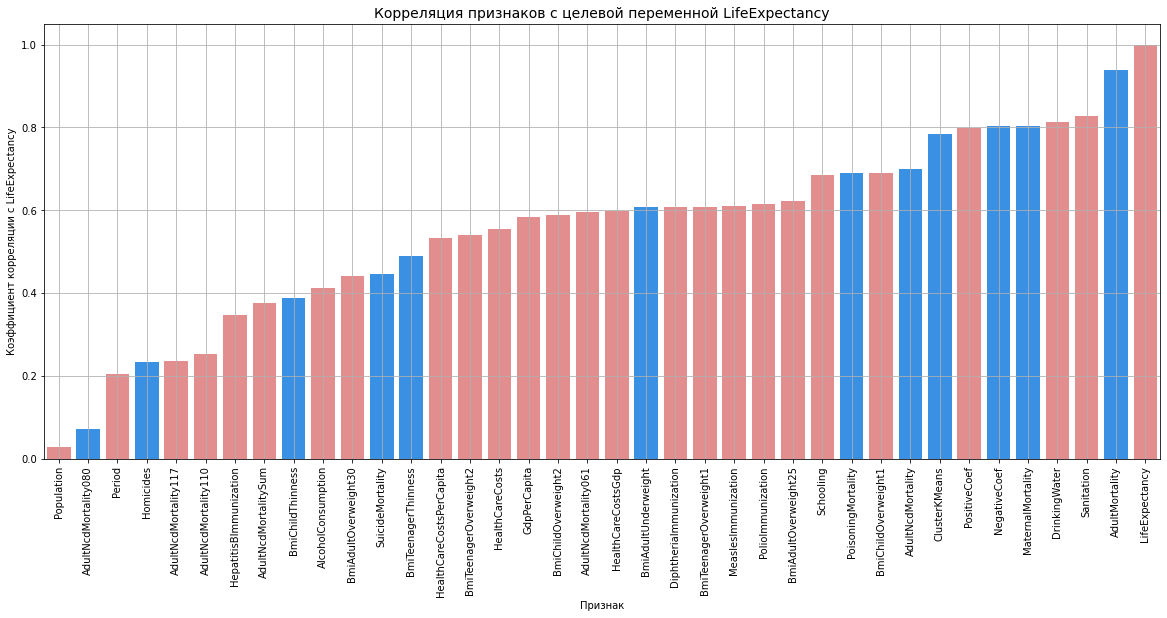

In [28]:
display_corellation_by_target(data, figsize=(20, 8))

Новые признаки имеют коэффициенты корреляции с целевой переменной близкие к 0.8, что неплохо.